In [ ]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import optax
from jax import random, vmap, numpy as jnp

import matplotlib.pyplot as plt

from data.dataset import load_dataset
from data.graph_utils import spmatrix_to_graph
from config import default_precorrector_config
from scipy_linsolve import make_Chol_prec_from_bcoo, batched_cg_scipy
from train import construction_time_with_gnn, train_inference_finetune, make_PreCorrector

In [3]:
jnp.ones(1);

2025-01-15 07:11:23.077856: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
path = '/mnt/local/data/vtrifonov/prec-learning-Notay-loss/'
trained_models_path = os.path.join(path, 'trained_models')
key = random.PRNGKey(42)

name = 'check_rebuilt_code_dkg128.eqx'

In [34]:
config = {
    'model_path': os.path.join(trained_models_path, name), 
    'model_use': 'fine-tune',
    'save_model': True,
    'cg_maxiter': 100,
    'cg_atol': 1e-9
}

data_config = {
    'data_dir': path,
    'pde': 'div_k_grad',
    'grid': 128,
    'variance': .1,
    'lhs_type': 'l_ic0',
    'N_samples_train': 1000,
    'N_samples_test': 200,
    'precision': 'f64',
    'fill_factor': '-',
    'threshold': '-'
}

model_config = default_precorrector_config

train_config = {
    'loss_type': 'low_freq_loss',
    'model_type': 'precorrector',
    'batch_size': 8,
    'optimizer': optax.adam,
    'lr': 1e-3,
    'optim_params': {},
    'epoch_num': 10
}

In [6]:
train_set = load_dataset(data_config, return_train=True)
A_train, A_pad_train, b_train, bi_edges_train, x_train, ic_time_mean_train, ic_time_std_train = train_set

test_set = load_dataset(data_config, return_train=False)
A_test, A_pad_test, b_test, bi_edges_test, x_test, ic_time_mean_test, ic_time_std_test = test_set

data = (
    [A_train, A_pad_train, b_train, bi_edges_train, x_train],
    [A_test, A_pad_test, b_test, bi_edges_test, x_test]
)

In [7]:
ic_time_mean_test, ic_time_std_test

(0.00045732637867331507, 8.08188030680627e-06)

In [35]:
model, losses, _ = train_inference_finetune(key, data, make_PreCorrector, model_config, train_config,
                                            model_path=config['model_path'], model_use=config['model_use'],
                                            load_model=config['load_model'], save_model=config['save_model'])

/mnt/local/data/vtrifonov/prec-learning-Notay-loss/train.py:29: UserWarning: Path leads to a trained model. It will be overwritten.
  warnings.warn('Path leads to a trained model. It will be overwritten.')


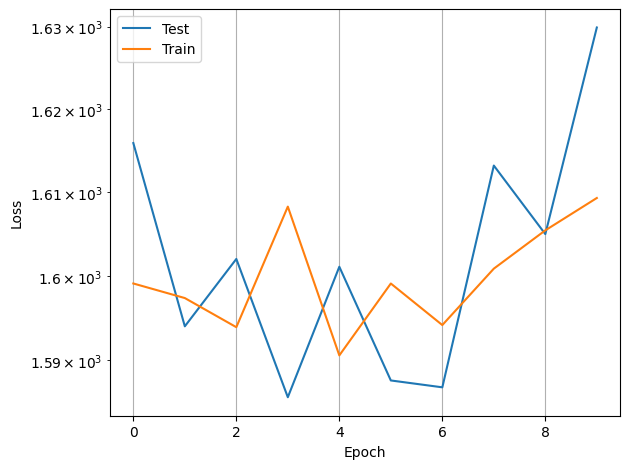

In [37]:
plt.plot(range(len(losses[0])), losses[1], label='Test')
plt.plot(range(len(losses[0])), losses[0], label='Train')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout();

In [38]:
time_gnn_mean, time_gnn_std = construction_time_with_gnn(model, A_test[0, ...], A_pad_test[0, ...], b_test[0, ...],
                                                         bi_edges_test[0, ...], num_rounds=A_test.shape[0],
                                                         pre_time_ic=ic_time_mean_test)

In [39]:
time_gnn_mean, time_gnn_std

(0.0008394246175885202, 8.005836076365258e-05)

In [40]:
L = vmap(model, in_axes=(0), out_axes=(0))(spmatrix_to_graph(A_pad_test, b_test))
P = make_Chol_prec_from_bcoo(L)

In [41]:
iters_stats, time_stats, nan_flag = batched_cg_scipy(A_test, b_test, time_gnn_mean, 'random',
                                                     random.PRNGKey(42), P, config['cg_atol'],
                                                     config['cg_maxiter'], thresholds=[1e-3, 1e-6, 1e-9, 1e-12])

/tmp/ipykernel_929937/1524581570.py:37: RuntimeWarning: Mean of empty slice
  np.round(np.nanmean(iter_time_per_res[:, j, 0]), 1),
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_929937/1524581570.py:41: RuntimeWarning: Mean of empty slice
  np.round(np.nanmean(iter_time_per_res[:, j, 1]), 4),


In [42]:
iters_stats, time_stats, nan_flag

({0.001: [54.6, 1.37],
  1e-06: [68.6, 1.61],
  1e-09: [82.2, 2.08],
  1e-12: [nan, nan]},
 {0.001: [0.3696, 0.05602],
  1e-06: [0.4639, 0.06941],
  1e-09: [0.5553, 0.08341],
  1e-12: [nan, nan]},
 {0.001: 0, 1e-06: 0, 1e-09: 0, 1e-12: 200})

In [31]:
P_ic0 = make_Chol_prec_from_bcoo(A_pad_test)
iters_stats_ic0, time_stats_ic0, nan_flag_ic0 = batched_cg_scipy(A_test, b_test, ic_time_mean_test, 'random',
                                                                 random.PRNGKey(42), P_ic0, config['cg_atol'],
                                                                 config['cg_maxiter'], thresholds=[1e-3, 1e-6, 1e-9, 1e-12])

/tmp/ipykernel_929937/1524581570.py:37: RuntimeWarning: Mean of empty slice
  np.round(np.nanmean(iter_time_per_res[:, j, 0]), 1),
/tmp/ipykernel_929937/1524581570.py:41: RuntimeWarning: Mean of empty slice
  np.round(np.nanmean(iter_time_per_res[:, j, 1]), 4),


In [32]:
iters_stats_ic0, time_stats_ic0, nan_flag_ic0

({0.001: [132.1, 1.94],
  1e-06: [168.8, 2.18],
  1e-09: [197.7, 1.48],
  1e-12: [nan, nan]},
 {0.001: [0.8323, 0.1092],
  1e-06: [1.0634, 0.14237],
  1e-09: [1.2449, 0.1677],
  1e-12: [nan, nan]},
 {0.001: 0, 1e-06: 0, 1e-09: 27, 1e-12: 200})